In [ ]:
import os
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from transformers import AutoConfig, AutoModelForSequenceClassification

sys.path.append('..')
from src.product_quantization import PQEmbedding, model_size, cosine_similarity, quantize_bert

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
model.eval();

### Hyperparameters Fine-Tuning

In [3]:
num_clusters = 2 ** np.arange(4, 9)
n_dims = 768 // np.array([2, 3, 4, 6, 8])

if not os.path.isfile('similarities.npy'):
    embeddngs_orig = model.bert.embeddings.word_embeddings.weight.data.numpy()

    original_size = model_size(model)
    original_similarity = np.ones(1)

    similarities = []
    relative_size = []

    for dim in tqdm(n_dims):
        for num_cluster in tqdm(num_clusters):

            pq_embeddings = PQEmbedding(model.bert.embeddings.word_embeddings, dim=dim, num_clusters=num_cluster)
            embeddngs_quant = pq_embeddings(torch.arange(len(embeddngs_orig)).unsqueeze(0))[0].numpy()
            similarity = cosine_similarity(embeddngs_orig, embeddngs_quant).mean()

            similarities.append(similarity)
            relative_size.append(original_size / pq_embeddings.size)

    np.save('similarities.npy', similarities)
    np.save('relative_size.npy', relative_size)

else:
    similarities = np.load('similarities.npy')
    relative_size = np.load('relative_size.npy')

dims_ratio = 768 // n_dims
n_bits = np.log2(num_clusters).astype(int)

x, y = np.meshgrid(n_bits, dims_ratio)

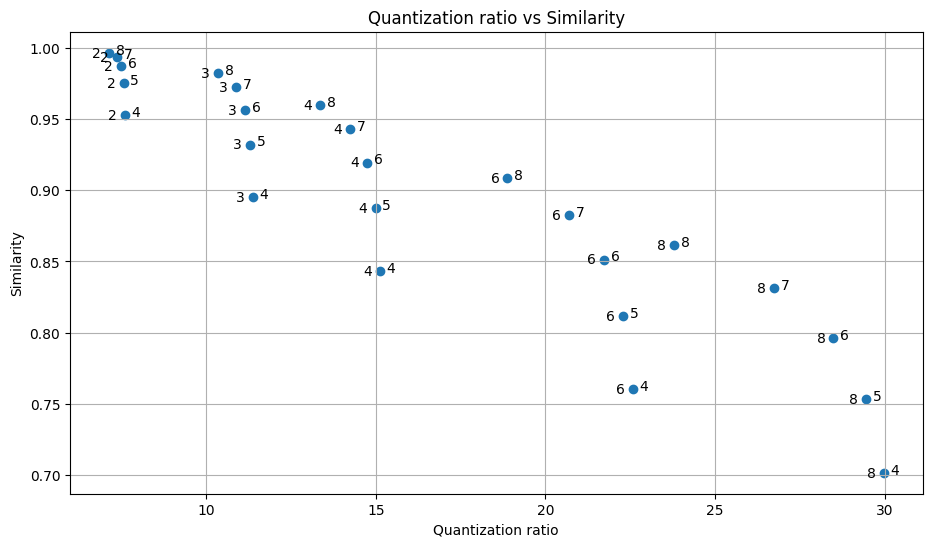

In [4]:
plt.figure(figsize=(11, 6))

plt.title('Quantization ratio vs Similarity')
plt.scatter(relative_size, similarities)
plt.xlabel('Quantization ratio')
plt.ylabel('Similarity')

for text, size, sim in zip(x.reshape(-1), relative_size, similarities):
    plt.annotate(text, (size + 0.2, sim - 0.0009), size=10)

for text, size, sim in zip(y.reshape(-1), relative_size, similarities):
    plt.annotate(text, (size - 0.5, sim - 0.003), size=10)

plt.grid()
plt.show()

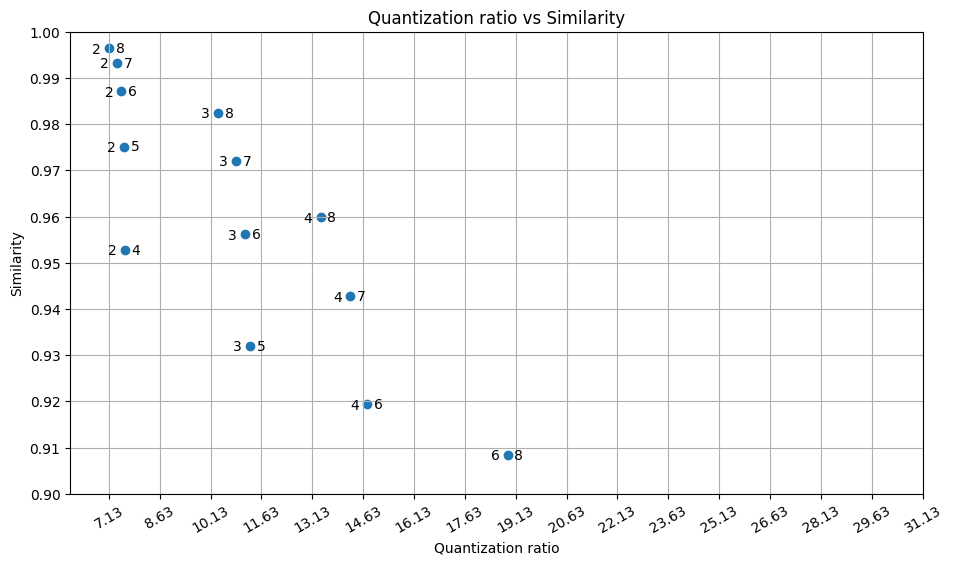

In [5]:
plt.figure(figsize=(11, 6))

plt.title('Quantization ratio vs Similarity')
plt.scatter(relative_size, similarities)
plt.xlabel('Quantization ratio')
plt.ylabel('Similarity')

plt.yticks(np.arange(0.9, max(similarities) + 0.01, 0.01))
plt.xticks(np.arange(min(relative_size), max(relative_size) + 1.5, 1.5), rotation=30)
plt.ylim(0.9, 1)

for text, size, sim in zip(x.reshape(-1), relative_size, similarities):
    plt.annotate(text, (size + 0.2, sim - 0.0009), size=10)

for text, size, sim in zip(y.reshape(-1), relative_size, similarities):
    plt.annotate(text, (size - 0.5, sim - 0.001), size=10)

plt.grid()
plt.show()

### Quantization Test (half precision)

##### Embeddings Quantization

In [6]:
quantized_model = quantize_bert(model, quant_linears=False)
model_size(model), model_size(quantized_model)

(413.25516986846924, 171.64884281158447)

##### Embeddings + Linear layers Quantization (with dynamic quantization)

In [8]:
quantized_model = quantize_bert(model, quant_linears=False)
quantized_model = torch.quantization.quantize_dynamic(quantized_model, {nn.Linear, nn.LayerNorm}, dtype=torch.qint8)
model_size(model), model_size(quantized_model)

(413.25516986846924, 90.14025974273682)

##### Embeddings + Linear layers Quantization (both with product quantization)

In [9]:
quantized_model = quantize_bert(model)
model_size(model), model_size(quantized_model)

(413.25516986846924, 132.312726020813)

### Quantization of Pre-Trained Models (half precision)

In [10]:
def load_model(path):
    num_labels = torch.load(f'{path}/pytorch_model.bin')['classifier.weight'].size()[0]
    config = AutoConfig.from_pretrained('bert-base-cased', num_labels=num_labels)
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', config=config)
    model.load_state_dict(torch.load(f'{path}/pytorch_model.bin'))
    return model

##### Embeddings Quantization

In [ ]:
tasks = ['stsb', 'cola', 'mnli', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'wnli']
for task in tqdm(tasks):
    path = f'../data/bert-3-epoch-fine-tuned/{task}'
    model = load_model(f'../data/bert-3-epoch-fine-tuned/{task}')
    
    model = quantize_bert(model, quant_linears=False)

    torch.save(model, f'{path}/pq_model.bin')

##### Embeddings (PQ) + linear layers quantization (dynamic quantization)

In [ ]:
tasks = ['stsb', 'cola', 'mnli', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'wnli']
for task in tqdm(tasks):
    path = f'../data/bert-3-epoch-fine-tuned/{task}'
    model = load_model(f'../data/bert-3-epoch-fine-tuned/{task}')
    
    model = quantize_bert(model, quant_linears=False, half_precision=False)
    model = torch.quantization.quantize_dynamic(model, {nn.Linear, nn.LayerNorm}, dtype=torch.qint8)

    torch.save(model, f'{path}/pq_dynamic_model.bin')

##### Embeddings + linear layers quantization (both with PQ)

In [13]:
tasks = ['stsb', 'cola', 'mnli', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'wnli']
for task in tqdm(tasks):
    path = f'../data/bert-3-epoch-fine-tuned/{task}'
    model = torch.load(f'{path}/pq_model.bin')
    
    model = quantize_bert(model, quant_vocab=False)
    torch.save(model, f'{path}/quantinized_model_all.bin')

In [14]:
import pandas as pd


pd.read_csv('../results.csv').iloc[[3, 4, 7, 9, 8, 5, 6]]

,model,score,size(MB),SPS,used_cpu,used_cpu_mem,used_gpu,used_gpu_mem,stsb,cola,mnli,mrpc,qnli,qqp,rte,sst2,wnli
3,bert-default,0.771,413.185,555.819,5.295,3658.889,28.481,8201.382,0.882,0.555,0.840,0.870,0.907,0.875,0.650,0.914,0.451
4,bert-default-fp16,0.770,206.596,1121.283,5.041,3379.000,33.944,3852.292,0.882,0.555,0.840,0.870,0.907,0.875,0.650,0.914,0.437
7,bert-pq-embeddings,0.772,336.064,496.443,11.381,3757.778,29.000,8052.153,0.883,0.555,0.838,0.868,0.906,0.874,0.646,0.916,0.465
9,bert-pq-embeddings-fp16,0.769,171.578,1121.878,5.082,3599.667,35.833,3655.208,0.882,0.547,0.838,0.871,0.907,0.874,0.639,0.915,0.451
8,bert-pq-embeddings-dynamic-linears,0.748,9.489,35.897,51.921,3902.667,13.556,8351.069,0.870,0.444,0.798,0.849,0.890,0.854,0.617,0.905,0.507
5,bert-pq-all-layers,0.772,174.410,488.007,5.342,3167.000,41.667,4323.812,0.881,0.552,0.837,0.867,0.906,0.874,0.635,0.915,0.479
6,bert-pq-all-layers-fp16,0.772,132.173,983.312,5.089,3174.444,35.611,3651.299,0.881,0.552,0.837,0.867,0.906,0.874,0.635,0.915,0.479


In [15]:
data = pd.read_csv('../results.csv').iloc[[3, 4, 6, 9, 8], 1]

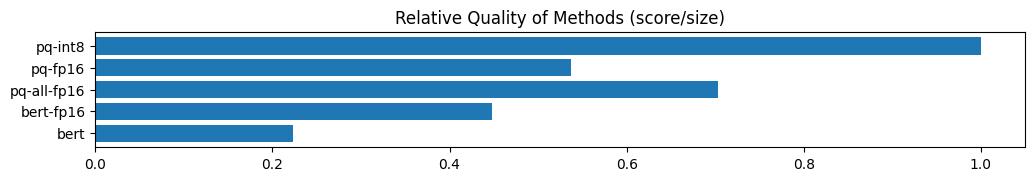

In [16]:
names = ['bert', 'bert-fp16', 'pq-all-fp16', 'pq-fp16', 'pq-int8']
sizes = np.array([433, 216, 138, 180, 94])
scores = data.values
scores = scores / sizes
scores /= scores.max()

plt.figure(figsize=(12, 1.5))

plt.title('Relative Quality of Methods (score/size)')
plt.barh(names, scores)

plt.show()